# Causal curiosity (récap des tâches)

## Import

In [ ]:
pip install StructuralCausalModels


In [ ]:
pip install causal_learn

In [ ]:
pip install pydot

## Tests

In [ ]:
import numpy as np
import scipy.stats as stats
from StructuralCausalModels.linear_structural_causal_model import LinearStructuralCausalModel
from StructuralCausalModels.structural_equation import StructuralEquation
import matplotlib.pyplot as plt

# Define the structural equations
structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[1], exogenous_variable=stats.norm(), function=lambda u, x: u + x ),  # Adjusted lambda function
    StructuralEquation(index_lhs=1, indices_rhs=[], exogenous_variable=stats.norm(), function=lambda u:  u)  # Adjusted lambda function
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='Example SCM', nb_var=2, structural_equations=structural_equations)

# Generate data from the SCM
data = linear_scm.generate_data(nb_samples=100)

# Print the generated data
print(data)

plt.plot(data)


In [ ]:
# Define the new structural equation for intervention
new_structural_equation = StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(), function=lambda u: u + 1)
new_structural_equation = StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(), function=lambda u: u - 1)

# Perform intervention
post_intervention_scm = linear_scm.perform_intervention(new_structural_equation)

# Print the post-intervention SCM
print(post_intervention_scm)

data_in = post_intervention_scm.generate_data(nb_samples=100)

plt.plot(data_in)


In [ ]:
import numpy as np
import scipy.stats as stats
from StructuralCausalModels.linear_structural_causal_model import LinearStructuralCausalModel
from StructuralCausalModels.structural_equation import StructuralEquation


N = 1000
# Define the discrete value sets
discrete_values_X0 = [i for i in range(-N, N)]
discrete_values_X1 = [i for i in range(-N, N)]
discrete_values_X2 = [i for i in range(-N, N)]

# Define the quantization function
def quantize(value, discrete_values):
    return [min(discrete_values, key=lambda x: abs(x - v)) for v in value]
# Modify the structural equations to produce discrete outputs
structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u: quantize(u, discrete_values_X0)),
    StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u, discrete_values_X1)),
    StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u, discrete_values_X2))
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='Example SCM', nb_var=3, structural_equations=structural_equations)

# Generate data from the SCM
data = linear_scm.generate_data(nb_samples=100)

print(linear_scm.adjacency_matrix())
# Print the generated data
print(data)
print((data.mean()))

In [ ]:
from causallearn.search.HiddenCausal.GIN.GIN import GIN
G, K = GIN(data.to_numpy())

G.__str__()

## Def env

In [ ]:
class CausalEnv:
    def __init__(self, scm, actions):
        self.scm = scm 
        self.current_step = 0
        self.max_step = 1000
        self.actions = actions

    def step(self, action):
        if not (action == None):
            new_scm = self.scm.perform_intervention(actions[action].intervention)
            sample = new_scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
        else:
            sample = self.scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
            
        self.current_step += 1
        done = (self.current_step >= self.max_step)
        info = {}
        reward = self.compute_reward(next_state)
        return next_state.to_numpy(), reward, done, info

    def reset(self):
        sample = self.scm.generate_data(nb_samples=100)
        state = np.floor(sample.mean())
        reward = self.compute_reward(state)
        
        return state.to_numpy()

    def compute_reward(self, state):
        return state.to_numpy()[-1]

class Action:
    def __init__(self, intervention):
        self.intervention = intervention

        

In [ ]:
action = Action(new_structural_equation)
cv = CausalEnv(linear_scm, [action])

In [ ]:
cv.step(None)

Je vais définir deux actions pour chacune des variables: une avec un +1 et une autre avec un -1

In [ ]:
intervention_X0_neg = StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u - 1, discrete_values_X0))
intervention_X0_pos =  StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u + 1, discrete_values_X0))
action_X0_pos = Action(intervention_X0_pos)
action_X0_neg = Action(intervention_X0_neg)

intervention_X1_neg = StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u - 1, discrete_values_X1))
intervention_X1_pos =  StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u + 1, discrete_values_X1))
action_X1_pos = Action(intervention_X1_pos)
action_X1_neg = Action(intervention_X1_neg)

intervention_X2_neg = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u - 1, discrete_values_X2))
intervention_X2_pos = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u + 1, discrete_values_X2))
action_X2_pos = Action(intervention_X2_pos)
action_X2_neg = Action(intervention_X2_neg)




In [ ]:
actions = [action_X0_neg, action_X0_pos, action_X1_neg, action_X1_pos, action_X2_neg, action_X2_pos]

## Def Agent

In [ ]:
import numpy as np
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.Q = {}  # Dictionary to store Q-values
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state
        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)
        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)
        self.Q[state_key][action] = new_q_value
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state
        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.argmax(self.Q[state_key])  # Exploit
            
    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(10)):
                action = self.choose_action(state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                
            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay
        return cumulative_rewards, exploration_behavior

In [ ]:
actions = [action_X0_neg, action_X0_pos, action_X1_neg, action_X1_pos, action_X2_neg, action_X2_pos]

structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u: quantize(u, discrete_values_X0)),
    StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u, discrete_values_X1)),
    StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u, discrete_values_X2))
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='Example SCM', nb_var=3, structural_equations=structural_equations)

env = CausalEnv(scm=linear_scm, actions=actions)

# Initialize the Q-learning agent
agent = QLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99)

# Train the agent
num_episodes = 1000
cumulative_rewards, exploration_behavior = agent.train(num_episodes)

# Plot cumulative reward
plt.figure(figsize=(10, 6))

plt.plot(range(num_episodes), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.show()

# Plot exploration behavior

plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), exploration_behavior)
plt.xlabel('Episode')
plt.ylabel('Exploration Count')
plt.title('Exploration Behavior over Episodes')
plt.show()

## Def agent causal


In [ ]:
import numpy as np
from tqdm import tqdm

from cdt.metrics import precision_recall, SID, SHD
from tqdm import tqdm
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph import SHD


def shd_cl_metric(new_graph, graph):

    metric = SHD.SHD(new_graph, graph)

    return metric.get_shd()

def pc_algo(history):
    
    #print('pc hsitory', history)
    array_data = np.array(history) #dicts_to_numpy_array(history)

    
    cg = pc(array_data, alpha=0.2, verbose=False, show_progress=False)     #, alpha=0.05, indep_test="chisq")
    

    return cg.G

class CausalQLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, beta=0.2):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.beta = beta
        self.Q = {}  # Dictionary to store Q-values
        self.D = {}
        self.history = []
        self.causal_graph = None
        
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state

        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)

        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)

        self.Q[state_key][action] = new_q_value

    def update_causal_graph(self, causal_discovery_algo=pc_algo, graph_distance_metric=shd_cl_metric):
        
        new_causal_graph = causal_discovery_algo(self.history) 

        if self.causal_graph == None:
            self.causal_graph = new_causal_graph

        graph_distance = graph_distance_metric(new_causal_graph, self.causal_graph) # un peu là aussi

        return new_causal_graph, graph_distance


    def update_D(self, action, graph_distance):

        
        if action not in self.D:
            self.D[action] = 0
        
        self.D[action] = self.beta * graph_distance
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state

        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.argmax(self.D)  # Causal exploration

        else:
            return np.argmax(self.Q[state_key])  # Exploit


    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []

        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(100)):
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)

                self.history.append(next_state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                    if len(self.history) > 5:
                        new_causal_graph, graph_distance = self.update_causal_graph()
                        self.update_D(action, graph_distance)

                state = next_state
                episode_reward += reward
                

            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay

        return cumulative_rewards, exploration_behavior

In [ ]:
actions = [action_X0_neg, action_X0_pos, action_X1_neg, action_X1_pos, action_X2_neg, action_X2_pos]

structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u: quantize(u, discrete_values_X0)),
    StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u, discrete_values_X1)),
    StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u, discrete_values_X2))
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='Example SCM', nb_var=3, structural_equations=structural_equations)

env = CausalEnv(scm=linear_scm, actions=actions)

# Initialize the Q-learning agent
agent = QLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99)
causal_agent = CausalQLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, beta=0.3 )
# Train the agent
num_episodes = 1000
causal_cumulative_rewards, causal_exploration_behavior = causal_agent.train(num_episodes)
cumulative_rewards, exploration_behavior = agent.train(num_episodes)
# Plot cumulative reward
plt.figure(figsize=(10, 6))

plt.plot(range(num_episodes), cumulative_rewards)
plt.plot(range(num_episodes), causal_cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.show()

# Plot exploration behavior

plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), causal_exploration_behavior)
plt.plot(range(num_episodes), exploration_behavior)
plt.xlabel('Episode')
plt.ylabel('Exploration Count')
plt.title('Exploration Behavior over Episodes')
plt.show()

# Tentative d'optimisation

In [ ]:
pip install cython        

In [ ]:
%load_ext cython

In [ ]:
%%cython -a

import numpy as np
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.Q = {}  # Dictionary to store Q-values
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state
        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)
        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)
        self.Q[state_key][action] = new_q_value
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state
        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.argmax(self.Q[state_key])  # Exploit
            
    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(10)):
                action = self.choose_action(state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                
            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay
        return cumulative_rewards, exploration_behavior


class BaselineAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.Q = {}  # Dictionary to store Q-values
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state
        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)
        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)
        self.Q[state_key][action] = new_q_value
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state
        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.random.randint(self.num_actions)  # Exploit
            
    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []
        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(10)):
                action = self.choose_action(state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                next_state, reward, done, _ = self.env.step(action)
                #self.update_Q(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                
            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay
        return cumulative_rewards, exploration_behavior


import numpy as np
from tqdm import tqdm

from cdt.metrics import precision_recall, SID, SHD
from tqdm import tqdm
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph import SHD


def shd_cl_metric(new_graph, graph):

    metric = SHD.SHD(new_graph, graph)

    return metric.get_shd()

def pc_algo(history):
    
    #print('pc hsitory', history)
    array_data = np.array(history) #dicts_to_numpy_array(history)

    
    cg = pc(array_data, alpha=0.2, verbose=False, show_progress=False)     #, alpha=0.05, indep_test="chisq")
    

    return cg.G

class CausalQLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, beta=0.2):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.num_actions = len(env.actions) 
        self.beta = beta
        self.Q = {}  # Dictionary to store Q-values
        self.D = {}
        self.history = []
        self.causal_graph = None
        
        
    def update_Q(self, state, action, reward, next_state):
        # Convert states to tuple keys if they are not already
        state_key = tuple(state.ravel()) if isinstance(state, (np.ndarray)) else state
        next_state_key = tuple(next_state.ravel()) if isinstance(next_state, (np.ndarray)) else next_state

        # Initialize Q-values for unseen states
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
        if next_state_key not in self.Q:
            self.Q[next_state_key] = np.zeros(self.num_actions)

        # Update Q-value using the Q-learning formula
        old_q_value = self.Q[state_key][action]
        max_next_q_value = np.max(self.Q[next_state_key])
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_next_q_value - old_q_value)

        self.Q[state_key][action] = new_q_value

    def update_causal_graph(self, causal_discovery_algo=pc_algo, graph_distance_metric=shd_cl_metric):
        
        new_causal_graph = causal_discovery_algo(self.history) 

        if self.causal_graph == None:
            self.causal_graph = new_causal_graph

        graph_distance = graph_distance_metric(new_causal_graph, self.causal_graph) # un peu là aussi

        return new_causal_graph, graph_distance


    def update_D(self, action, graph_distance):

        
        if action not in self.D:
            self.D[action] = 0
        
        self.D[action] = self.beta * graph_distance
        
    def choose_action(self, state):
        
        # Ensure state is converted to a hashable type (tuple) if it's a numpy array
        state_key = tuple(state.ravel()) if isinstance(state, np.ndarray) else state

        # Decide to explore or exploit
        if state_key not in self.Q or np.random.rand() < self.epsilon:
            return np.argmax(self.D)  # Causal exploration

        else:
            return np.argmax(self.Q[state_key])  # Exploit


    def train(self, num_episodes):
        cumulative_rewards = []
        exploration_behavior = []

        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            episode_reward = 0
            exploration_count = 0
            
            for _ in (range(100)):
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_Q(state, action, reward, next_state)

                self.history.append(next_state)
                if np.random.rand() < self.epsilon:
                    exploration_count += 1
                    if len(self.history) > 5:
                        new_causal_graph, graph_distance = self.update_causal_graph()
                        self.update_D(action, graph_distance)

                state = next_state
                episode_reward += reward
                

            cumulative_rewards.append(episode_reward)
            exploration_behavior.append(exploration_count)
            self.epsilon *= self.epsilon_decay

        return cumulative_rewards, exploration_behavior

import numpy as np
import scipy.stats as stats
from StructuralCausalModels.linear_structural_causal_model import LinearStructuralCausalModel
from StructuralCausalModels.structural_equation import StructuralEquation
import matplotlib.pyplot as plt

N = 100
# Define the discrete value sets
discrete_values_X0 = [i for i in range(-N, N)]
discrete_values_X1 = [i for i in range(-N, N)]
discrete_values_X2 = [i for i in range(-N, N)]

# Define the quantization function
def quantize(value, discrete_values):
    return [min(discrete_values, key=lambda x: abs(x - v)) for v in value]

class CausalEnv:
    def __init__(self, scm, actions):
        self.scm = scm 
        self.current_step = 0
        self.max_step = 1000
        self.actions = actions

    def step(self, action):
        if not (action == None):
            new_scm = self.scm.perform_intervention(actions[action].intervention)
            sample = new_scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
        else:
            sample = self.scm.generate_data(nb_samples = 100)
            next_state = np.floor(sample.mean())
            
        self.current_step += 1
        done = (self.current_step >= self.max_step)
        info = {}
        reward = self.compute_reward(next_state)
        return next_state.to_numpy(), reward, done, info

    def reset(self):
        sample = self.scm.generate_data(nb_samples=100)
        state = np.floor(sample.mean())
        reward = self.compute_reward(state)
        
        return state.to_numpy()

    def compute_reward(self, state):
        return state.to_numpy()[-1]

class Action:
    def __init__(self, intervention):
        self.intervention = intervention

        


intervention_X0_neg = StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u - 1, discrete_values_X0))
intervention_X0_pos =  StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u : quantize(u + 1, discrete_values_X0))
action_X0_pos = Action(intervention_X0_pos)
action_X0_neg = Action(intervention_X0_neg)

intervention_X1_neg = StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u - 1, discrete_values_X1))
intervention_X1_pos =  StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u + 1, discrete_values_X1))
action_X1_pos = Action(intervention_X1_pos)
action_X1_neg = Action(intervention_X1_neg)

intervention_X2_neg = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u - 1, discrete_values_X2))
intervention_X2_pos = StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u + 1, discrete_values_X2))
action_X2_pos = Action(intervention_X2_pos)
action_X2_neg = Action(intervention_X2_neg)





actions = [action_X0_neg, action_X0_pos, action_X1_neg, action_X1_pos, action_X2_neg, action_X2_pos]

structural_equations = [
    StructuralEquation(index_lhs=0, indices_rhs=[], exogenous_variable=stats.norm(loc=0, scale=100),
                        function=lambda u: quantize(u, discrete_values_X0)),
    StructuralEquation(index_lhs=1, indices_rhs=[0], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(0.5 * x + u, discrete_values_X1)),
    StructuralEquation(index_lhs=2, indices_rhs=[1], exogenous_variable=stats.norm(loc=0, scale=100),
                       function=lambda u, x: quantize(-0.7 * x + u, discrete_values_X2))
]

# Create a linear SCM
linear_scm = LinearStructuralCausalModel(name='Example SCM', nb_var=3, structural_equations=structural_equations)

env = CausalEnv(scm=linear_scm, actions=actions)

# Initialize the Q-learning agent
baseline = BaselineAgent(env)
agent = QLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99)
causal_agent = CausalQLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, beta=0.3)

# Train the agent
num_episodes = 1000
baseline_rewards, baseline_exploration = baseline.train(num_episodes)
causal_cumulative_rewards, causal_exploration_behavior = causal_agent.train(num_episodes)
cumulative_rewards, exploration_behavior = agent.train(num_episodes)
# Plot cumulative reward
plt.figure(figsize=(10, 6))

plt.plot(range(num_episodes), cumulative_rewards)
#plt.plot(range(num_episodes), causal_cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.show()

# Plot exploration behavior

plt.figure(figsize=(10, 6))
#plt.plot(range(num_episodes), causal_exploration_behavior)
plt.plot(range(num_episodes), exploration_behavior)
plt.xlabel('Episode')
plt.ylabel('Exploration Count')
plt.title('Exploration Behavior over Episodes')
plt.show()

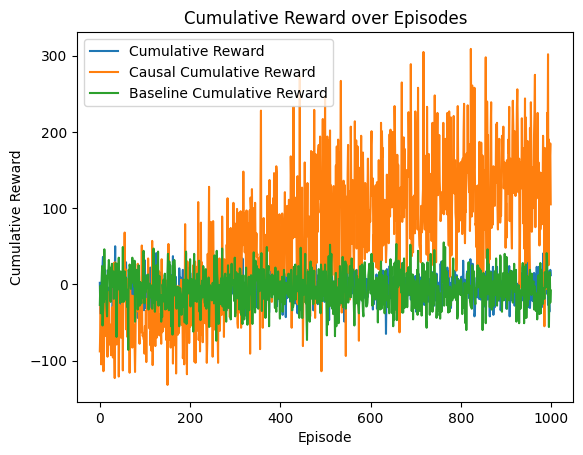

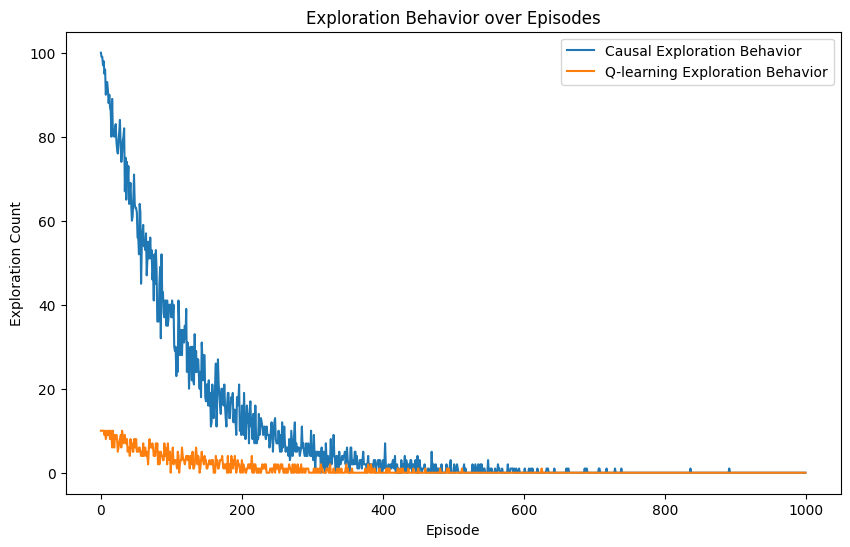

In [88]:
import matplotlib.pyplot as plt

# Supposons que num_episodes, cumulative_rewards, et causal_cumulative_rewards soient déjà définis

plt.plot(range(num_episodes), cumulative_rewards, label='Cumulative Reward')
plt.plot(range(num_episodes), causal_cumulative_rewards, label='Causal Cumulative Reward')
plt.plot(range(num_episodes), baseline_rewards, label='Baseline Cumulative Reward')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Episodes')
plt.legend()  # Ajoute la légende
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), causal_exploration_behavior, label='Causal Exploration Behavior')
plt.plot(range(num_episodes), exploration_behavior, label='Q-learning Exploration Behavior')
#plt.plot(range(num_episodes), baseline_exploration, label='Baseline Exploration')
plt.xlabel('Episode')
plt.ylabel('Exploration Count')
plt.title('Exploration Behavior over Episodes')
plt.legend()  # Ajoute la légende
plt.show()



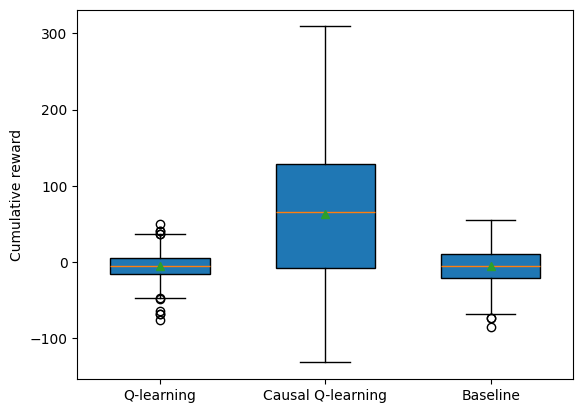

In [83]:
# Regroupement des données dans une liste pour le boxplot
data = [cumulative_rewards, causal_cumulative_rewards, baseline_rewards]

# Création du boxplot
plt.boxplot(data, patch_artist=True, showmeans=True, 
            positions=[1, 2, 3],  # Position de chaque boxplot
            widths=0.6)  # Largeur des boxplots pour éviter qu'ils soient trop étroits

# Ajout des étiquettes et du titre
plt.xticks([1, 2, 3], ['Q-learning', 'Causal Q-learning', 'Baseline'])
plt.ylabel('Cumulative reward')
#plt.title('Comparais')

plt.show()

In [80]:
causal_agent.Q

{(0.0,
  0.0,
  0.0): array([-0.5981064 , -0.37754072, -0.12457767, -0.686     , -0.7       ,
         1.43874498]),
 (-5.0,
  -3.0,
  6.0): array([-0.81956228, -0.54545466, -0.12258437, -0.35829802,  1.26407994,
         0.        ]),
 (3.0,
  5.0,
  1.0): array([-1.16649732, -1.3       , -0.2353    , -0.38221   , -0.43267189,
         4.84482149]),
 (2.0,
  3.0,
  -1.0): array([-1.18734353, -0.84474475, -0.65572257, -1.3       , -0.8       ,
         1.55436981]),
 (2.0,
  3.0,
  -3.0): array([-0.65939943, -0.58419711, -1.09076843,  1.2162536 , -0.65660933,
        -0.7       ]),
 (-4.0,
  -6.0,
  -7.0): array([-0.18999035, -0.3       , -0.0420916 ,  5.50913087,  0.        ,
         0.        ]),
 (-10.0,
  -11.0,
  1.0): array([ 1.03143529, -0.9966    , -0.76829536, -1.5       , -1.00034116,
        -0.79726188]),
 (-6.0,
  -6.0,
  1.0): array([-1.14953834, -0.9151129 , -1.24948173, -1.59770586, -1.22503036,
        -0.949     ]),
 (-5.0,
  -5.0,
  2.0): array([-0.41507901, -0.3607

In [81]:
agent.Q

{(17.0, 9.0, -4.0): array([0. , 0.8, 0. , 0. , 0. , 0. ]),
 (2.0, 2.0, 8.0): array([-1.2  ,  0.724,  0.   , -0.83 ,  0.   ,  0.   ]),
 (9.0, 10.0, 3.0): array([ 0. ,  0. ,  0. , -0.5,  0. ,  0. ]),
 (-2.0,
  -2.0,
  -5.0): array([-0.3      ,  1.1955222,  0.       ,  0.       ,  0.       ,
         0.       ]),
 (9.0, 8.0, -3.0): array([-0.3 , -0.51,  0.  ,  0.  ,  0.  ,  0.  ]),
 (8.0, 8.0, 1.0): array([-1.63, -0.2 ,  0.  ,  0.  ,  0.  , -0.2 ]),
 (-6.0,
  -5.0,
  -2.0): array([ 0.404374,  0.      ,  0.      ,  0.      , -0.43    ,  0.      ]),
 (1.0, -8.0, 3.0): array([ 0. ,  0. ,  0. , -0.9,  0. ,  0. ]),
 (-10.0, -9.0, -9.0): array([0. , 0. , 0. , 0.4, 0. , 0. ]),
 (-6.0,
  -4.0,
  4.0): array([-0.0199035,  1.09     ,  0.       ,  0.       ,  0.       ,
         0.       ]),
 (-5.0,
  -5.0,
  2.0): array([-0.475317,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ]),
 (1.0,
  3.0,
  -8.0): array([-1.4       ,  0.11982438,  0.        ,  0.        ,  0.        ,
         0.      

In [87]:
(causal_agent.causal_graph.node_map)

{<causallearn.graph.GraphNode.GraphNode at 0x31f156650>: 0,
 <causallearn.graph.GraphNode.GraphNode at 0x31f0e0090>: 1,
 <causallearn.graph.GraphNode.GraphNode at 0x31f0e2f10>: 2}